# Project 03 -- Take-Home Test

## Due Tuesday, March 12, 2024, 12:00 noon

1. Write a small python function to propagate two-body orbits using Kepler's equation (not numerical integration).<br>
`def orbit(a,e,i,w,raan,i):`<br>
    `stuff`<br>
    `return t, p`<br>

2. Apply this function to the satellite of your choosing by obtaining a current TLE for that satellite.
3. Create a ground track for that satellite for two orbit periods.
4. Make a sky plot for that satellite to observe it from the Clarkson campus (Potsdam, NY).

You can confer with each other, but please submit you own work.  


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [2]:
try:
    from modsim import *
except ImportError:
    print("Download modsim from the course repository at https://github.com/jeffwalton/AE470")

In [3]:
import numpy as np
import pandas as pd


In [4]:
mu_earth = 398600.4418 # km^3 / s ^2
r_earth = 6378.135 # km
w_earth = 7.2921159e-5 # radians/second

7.2921159e-05

In [5]:
import json
import requests
import configparser

def elset_spacetrack(sat_catno='25544', print_els=True):
    """
    requires space-track.ini file in current directory with these parameters
        [configuration]
        username = myUserName
        password = MyPa55W0rd    
    """
    uriBase                = "https://www.space-track.org"
    requestLogin           = "/ajaxauth/login"
    requestCmdAction       = "/basicspacedata/query" 
    
    config = configparser.ConfigParser()
    config.read("./space-track.ini")
    configUsr = config.get("configuration","username")
    configPwd = config.get("configuration","password")
    siteCred = {'identity': configUsr, 'password': configPwd}
    
    request_by_catno = f"/class/gp/NORAD_CAT_ID/{sat_catno}/orderby/TLE_LINE1%20ASC/format/json"

    class MyError(Exception):
        def __init___(self,args):
            Exception.__init__(self,"my exception was raised with arguments {0}".format(args))
            self.args = args

    with requests.Session() as session:
        # need to log in first. note that we get a 200 to say the web site got the data, not that we are logged in
        resp = session.post(uriBase + requestLogin, data = siteCred)
        if resp.status_code != 200:
            raise MyError(resp, "POST fail on login")
    
        resp = session.get(uriBase + requestCmdAction + request_by_catno)
        if resp.status_code != 200:
            print(resp)
            raise MyError(resp, "GET fail on request for elset by catno")
    
        retData = json.loads(resp.text)
    
        if print_els:
            for e in retData:
                print(e.keys())
                for k in e.keys():
                    print(f"{k} = {e[k]}")

        session.close()
    return retData[0]


In [6]:
def convert_angle_to_0_2pi_interval(angle):
    new_angle = np.arctan2(np.sin(angle), np.cos(angle))
    if new_angle < 0:
        new_angle = abs(new_angle) + 2 * (np.pi - abs(new_angle))
    return new_angle

angles = [10, 200, 365, -10, -180, 404.7]
print(np.rad2deg([convert_angle_to_0_2pi_interval(np.deg2rad(a)) for a in angles]))

[ 10.  200.    5.  350.  180.   44.7]


In [7]:
def convert_angle_to_plusminus_pi_interval(angle):
    new_angle = np.arctan2(np.sin(angle), np.cos(angle))
    if new_angle < -np.pi:
        new_angle = abs(new_angle) + 2*np.pi
    elif new_angle > np.pi:
        new_angle = abs(new_angle) - 2*np.pi
    return new_angle

angles = [10, 200, 365, -10, -180, 404.7]
print(np.rad2deg([convert_angle_to_plusminus_pi_interval(np.deg2rad(a)) for a in angles]))

[  10.  -160.     5.   -10.  -180.    44.7]


In [8]:
def orbital_elements(epoch, a, incl, ecc, Omega, w, M, n, T):
    return pd.Series(dict(epoch=epoch,
                          semimajor_axis=a,
                          inclination=incl,
                          eccentricity=ecc,
                          raan=Omega,
                          arg_perigee=w, 
                          mean_anomaly=M, 
                          mean_motion=n, 
                          orbit_period=T
                         ))

In [9]:
# retrieve orbital elements for Space Station from www.space-track.org
e = elset_spacetrack('25544',True)

epoch = pd.to_datetime(e['EPOCH'])
semimajor_axis = float(e['SEMIMAJOR_AXIS']) # km
inc = np.deg2rad(float(e['INCLINATION'])) # rad
ecc = float(e['ECCENTRICITY']) # non-dimensional
raan = np.deg2rad(float(e['RA_OF_ASC_NODE'])) # rad
arg_perigee = np.deg2rad(float(e['ARG_OF_PERICENTER'])) # rad
mean_anomaly = np.deg2rad(float(e['MEAN_ANOMALY'])) # rad
mean_motion = float(e['MEAN_MOTION']) * 2*np.pi / 24 / 60 / 60 # rad/second
orbit_period = float(e['PERIOD']) * 60 # seconds 

# print(epoch, semimajor_axis, inc, ecc, raan, arg_perigee, mean_anomaly, mean_motion, orbit_period)

init_orb_ele = orbital_elements(epoch, semimajor_axis, inc, ecc, raan, arg_perigee, mean_anomaly, mean_motion, orbit_period)

dict_keys(['CCSDS_OMM_VERS', 'COMMENT', 'CREATION_DATE', 'ORIGINATOR', 'OBJECT_NAME', 'OBJECT_ID', 'CENTER_NAME', 'REF_FRAME', 'TIME_SYSTEM', 'MEAN_ELEMENT_THEORY', 'EPOCH', 'MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'EPHEMERIS_TYPE', 'CLASSIFICATION_TYPE', 'NORAD_CAT_ID', 'ELEMENT_SET_NO', 'REV_AT_EPOCH', 'BSTAR', 'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS', 'PERIAPSIS', 'OBJECT_TYPE', 'RCS_SIZE', 'COUNTRY_CODE', 'LAUNCH_DATE', 'SITE', 'DECAY_DATE', 'FILE', 'GP_ID', 'TLE_LINE0', 'TLE_LINE1', 'TLE_LINE2'])
CCSDS_OMM_VERS = 3.0
COMMENT = GENERATED VIA SPACE-TRACK.ORG API
CREATION_DATE = 2024-03-14T10:16:17
ORIGINATOR = 18 SPCS
OBJECT_NAME = ISS (ZARYA)
OBJECT_ID = 1998-067A
CENTER_NAME = EARTH
REF_FRAME = TEME
TIME_SYSTEM = UTC
MEAN_ELEMENT_THEORY = SGP4
EPOCH = 2024-03-14T09:53:09.051648
MEAN_MOTION = 15.49907257
ECCENTRICITY = 0.00061680
INCLINATION = 51.6400
RA_OF_ASC_NODE = 65.1219
ARG_OF_PER

epoch             2024-03-14 09:53:09.051648
semimajor_axis                      6795.134
inclination                         0.901288
eccentricity                        0.000617
raan                                1.136592
arg_perigee                         0.087734
mean_anomaly                        2.599867
mean_motion                         0.001127
orbit_period                         5574.54
dtype: object

In [10]:
print(epoch, semimajor_axis, inc, ecc, raan, arg_perigee, mean_anomaly, mean_motion, orbit_period)

2024-03-14 09:53:09.051648 6795.134 0.9012880257298718 0.0006168 1.1365915701544953 0.08773421083925095 2.5998668883802813 0.0011271243639668302 5574.54


In [ ]:
# fixed values for testing
init_orb_ele = orbital_elements(pd.to_datetime('2024-03-11 12:10:02.989056'), 6795.393, 0.9012950070468797, 0.000615, 1.3877636481382514, 6.187565698779825, 2.454901586038884, 0.0011270600202222941, 5574.84)

In [11]:
# solve Kepler's equation
def keplers_equation(ecc, M, err_tol=1.0e-6, max_iter=10):
    if M < np.pi:
        E = M + ecc/2
    else:
        E = M - ecc/2
    ratio = 0.1
    # print(f"init: {ecc=}, {M=}, {err_tol=}, {max_iter=}, {E=}, {ratio=}")
    for iter in range(0,max_iter+1):
        # print(f"{iter=}, {E=}" )
        f = E - ecc*np.sin(E) - M
        f_prime = 1 - ecc*np.cos(E)
        ratio = f/f_prime
        E -= ratio
        # print(f"{f=}, {f_prime=}, {ratio=}, {E=}")
        if np.abs(ratio) < err_tol:
            break
    return E

In [12]:
def tbp_rv_from_elements(mu, orbital_elements, epoch_t0, epoch_t):
    """
    find r, v at epoch_t
    """
    # get elements
    epoch, a, incl, ecc, raan, w, M, n, _ = orbital_elements
    T = 2*np.pi/n

    # at epoch_t0, seconds since periapsis passage
    tp = M/n
    
    # time of new elements since periapsis passage
    t = ((epoch_t - epoch_t0) % T) + tp

    # find elements at t seconds since periapsis
    M_t = 2*np.pi*t/T
    M_t = convert_angle_to_0_2pi_interval(M_t)
    E_t = keplers_equation(ecc, M_t, err_tol=1e-8)
    E_t = convert_angle_to_0_2pi_interval(E_t)
    
    theta = 2 * np.arctan( np.sqrt((1+ecc)/(1-ecc))*np.tan(E_t/2) )
    theta = convert_angle_to_0_2pi_interval(theta)     
    theta_deg = np.rad2deg(theta)

    #define variable for sin and cos
    ct = np.cos(theta)
    st = np.sin(theta)
    craan = np.cos(raan)
    sraan = np.sin(raan)
    ci = np.cos(incl)
    si = np.sin(incl)
    com = np.cos(w)
    som = np.sin(w)
    #calculations
    p = a*(1-ecc**2)
    h = np.sqrt(p*mu)
    r = p/(1+ecc*np.cos(theta))
    rp_vec = np.matrix([r*ct, r*st, 0])
    vp_vec = np.matrix([((-mu/h)*st), (mu/h*(ecc+ct)), 0])
    Cgp = np.matrix([[(com*craan-sraan*ci*som), (-craan*som-sraan*ci*com), sraan*si],
                     [(sraan*com+craan*ci*som), (-sraan*som+craan*ci*com), -craan*si],
                     [si*som, si*com, ci]])
    r_vec = Cgp*np.transpose(rp_vec)
    v_vec = Cgp*np.transpose(vp_vec)
    # print(r_vec, r_vec.T, r_vec[0,0], r_vec[1,0])
    return t, np.rad2deg(M_t), theta_deg, np.rad2deg(E_t), r_vec[0,0], r_vec[1,0], r_vec[2,0], v_vec[0,0], v_vec[1,0], v_vec[2,0]


In [13]:
# test at t=0
tbp_rv_from_elements(mu_earth, init_orb_ele, 0.0, 0.0)

(2306.637112545632,
 148.9614,
 148.99781967425332,
 148.97961224239364,
 -4247.726444498908,
 -4767.348940922894,
 2334.925472730547,
 2.4624601815432423,
 -4.839980677239864,
 -5.3952371858220145)

In [48]:
def orbit(init_orb_ele, num_orbits=2, num_steps=100):
    time_0 = init_orb_ele.epoch
    t0 = 0.0 # seconds from epoch
    orbit_period = init_orb_ele.orbit_period  # seconds
    time_f = time_0 + pd.to_timedelta(num_orbits*orbit_period, unit='seconds')
    time_step = (time_f - time_0)/(num_orbits*num_steps)
    print(f"{time_0=}, {time_f=}, {time_step=}")

    # initialize orbit DataFrame
    orbit = pd.DataFrame(dict(t=np.arange(t0,num_orbits*orbit_period,time_step.total_seconds())), 
                            index=pd.date_range(start=time_0, end=time_f, periods=(num_orbits*num_steps+1)))

    orbit['tp'], orbit['M'], orbit['theta'], orbit['E'], orbit['r_x'], orbit['r_y'], orbit['r_z'], orbit['v_x'], orbit['v_y'], orbit['v_z'] = zip(*orbit.apply(lambda r: tbp_rv_from_elements(mu_earth, init_orb_ele, t0, r.t), axis=1))
    
    return orbit
    

In [73]:
orb = orbit(init_orb_ele, num_orbits=10)

time_0=Timestamp('2024-03-14 09:53:09.051648'), time_f=Timestamp('2024-03-15 01:22:14.451648'), time_step=Timedelta('0 days 00:00:55.745400')


,t,tp,M,theta,E,r_x,r_y,r_z,v_x,v_y,v_z
2024-03-14 09:53:09.051648,0.0000,2306.637113,148.961400,148.997820,148.979612,-4247.726444,-4767.348941,2334.925473,2.462460,-4.839981,-5.395237
2024-03-14 09:54:04.797048,55.7454,2362.382513,152.561408,152.593955,152.577684,-4102.177257,-5027.586149,2029.763283,2.757748,-4.493590,-5.549591
2024-03-14 09:55:00.542448,111.4908,2418.127913,156.161417,156.189963,156.175692,-3940.465115,-5268.014221,1716.603631,3.042155,-4.129514,-5.682072
2024-03-14 09:55:56.287848,167.2362,2473.873313,159.761425,159.785858,159.773643,-3763.227956,-5487.686888,1396.680735,3.314563,-3.749185,-5.792160
2024-03-14 09:56:52.033248,222.9816,2529.618713,163.361433,163.381656,163.371546,-3571.164723,-5685.739603,1071.255297,3.573902,-3.354101,-5.879424
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15 01:18:31.470048,55522.4184,7658.311651,134.569700,134.620025,134.594865,-4657.649252,-3550.656200,3451.519923,1.197015,-6.021950,-4.572983
2024-03-15 01:19:27.215448,55578.1638,7714.057051,138.169709,138.216820,138.193267,-4581.786349,-3879.134524,3189.962841,1.523850,-5.759129,-4.807919
2024-03-15 01:20:22.960848,55633.9092,7769.802451,141.769717,141.813429,141.791576,-4487.866042,-4192.324705,2915.833698,1.844655,-5.473632,-5.023888
2024-03-15 01:21:18.706248,55689.6546,7825.547851,145.369725,145.409866,145.389798,-4376.259801,-4488.993651,2630.213730,2.158168,-5.166585,-5.220045


In [74]:
import plotly.graph_objects as go
import plotly.express as px


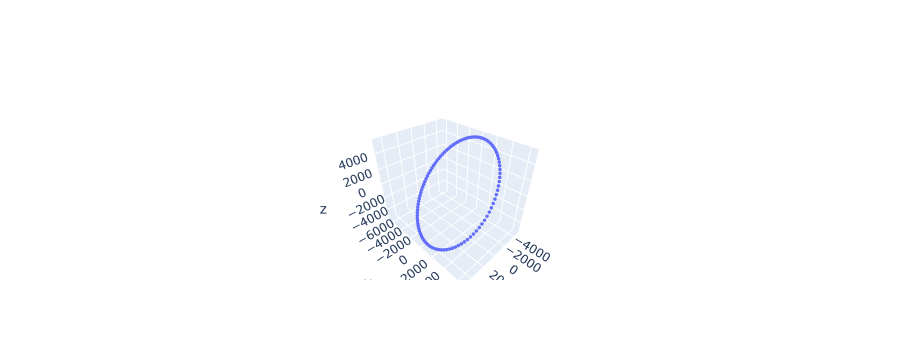

In [75]:
fig = go.Figure(
    data=[go.Scatter3d(
        x=orb.r_x,
        y=orb.r_y,
        z=orb.r_z,
        mode='markers',
        marker=dict(
            size=2
        )
    )
         ]
    )
fig.show()

In [76]:
from math import copysign, trunc

def julian_date( year, month, day, ut ):
    jd = 367*year - trunc((7*(year+trunc((month+9)/12)))/4) + trunc((275*month)/9) + day + 1721013.5 + ut/24 - \
        0.5*copysign(1.0,100*year+month-190002.5) + 0.5
    return jd

def decimal_hour(h, m, s):
    return h + m/60 + s/60/60

def hms(dh):
    mm,ss = divmod(abs(dh)*3600, 60)
    hh,mm = divmod(mm, 60)
    return hh,mm,ss

def gmst(jd0, h):
    dut = jd0 - 2451545.0 
    # gmst = (18.697375 + 24.065709824279*dut) % 24
    gmst = (6.697375 + 0.065709824279*dut + 1.0027379*h) % 24
    return gmst


In [77]:
print(epoch, type(epoch))

2024-03-14 09:53:09.051648 <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [78]:
print(epoch.date().year, epoch.date().month, epoch.date().day, epoch.hour, epoch.minute, epoch.second+(epoch.microsecond/1000000.0))

2024 3 14 9 53 9.051648


In [79]:
t1 = decimal_hour(epoch.hour,epoch.minute,epoch.second+(epoch.microsecond/1000000.0))
t2 = hms(t1)

print(f"{t1=}, {t2=}")

t1=9.88584768, t2=(9.0, 53.0, 9.051648000000569)


In [80]:
# EPOCH = 2024-03-11T12:10:02.989056
# g0 is the the GMST at EPOCH
print(f"{julian_date(2024,3,11,0.0)=}")
print(f"{decimal_hour(12,10,2.989056)=}")
g0 = gmst(julian_date(2024,3,11,0.0),decimal_hour(12,10,2.989056))
print(f"{g0=}, {hms(g0)=}")
hms(g0)

julian_date(2024,3,11,0.0)=2460380.5
decimal_hour(12,10,2.989056)=12.16749696
g0=23.47733776703126, hms(g0)=(23.0, 28.0, 38.41596131253755)


(23.0, 28.0, 38.41596131253755)

In [81]:
g0 = gmst(julian_date(epoch.date().year, epoch.date().month, epoch.date().day,0.0),decimal_hour(epoch.hour, epoch.minute, epoch.second+(epoch.microsecond/1000000.0)))


21.386571032304573

In [82]:
g0*15.0

320.7985654845686

In [83]:
np.deg2rad(g0*15.0)

5.59899120338036

In [84]:
def earth_rot(gmst0, t):
    """
    returns earth rotation angle since epoch
    parameters:
        gmst0: the the GMST at EPOCH
        t: time in seconds since EPOCH
    """
    return np.deg2rad(gmst0*15.0) + w_earth*(t)

In [85]:
orb['theta_earth'] = orb.apply(lambda r: convert_angle_to_0_2pi_interval(earth_rot(g0, r.t)), axis=1)

In [86]:
orb

,t,tp,M,theta,E,r_x,r_y,r_z,v_x,v_y,v_z,theta_earth
2024-03-14 09:53:09.051648,0.0000,2306.637113,148.961400,148.997820,148.979612,-4247.726444,-4767.348941,2334.925473,2.462460,-4.839981,-5.395237,5.598991
2024-03-14 09:54:04.797048,55.7454,2362.382513,152.561408,152.593955,152.577684,-4102.177257,-5027.586149,2029.763283,2.757748,-4.493590,-5.549591,5.603056
2024-03-14 09:55:00.542448,111.4908,2418.127913,156.161417,156.189963,156.175692,-3940.465115,-5268.014221,1716.603631,3.042155,-4.129514,-5.682072,5.607121
2024-03-14 09:55:56.287848,167.2362,2473.873313,159.761425,159.785858,159.773643,-3763.227956,-5487.686888,1396.680735,3.314563,-3.749185,-5.792160,5.611186
2024-03-14 09:56:52.033248,222.9816,2529.618713,163.361433,163.381656,163.371546,-3571.164723,-5685.739603,1071.255297,3.573902,-3.354101,-5.879424,5.615251
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15 01:18:31.470048,55522.4184,7658.311651,134.569700,134.620025,134.594865,-4657.649252,-3550.656200,3451.519923,1.197015,-6.021950,-4.572983,3.364565
2024-03-15 01:19:27.215448,55578.1638,7714.057051,138.169709,138.216820,138.193267,-4581.786349,-3879.134524,3189.962841,1.523850,-5.759129,-4.807919,3.368630
2024-03-15 01:20:22.960848,55633.9092,7769.802451,141.769717,141.813429,141.791576,-4487.866042,-4192.324705,2915.833698,1.844655,-5.473632,-5.023888,3.372695
2024-03-15 01:21:18.706248,55689.6546,7825.547851,145.369725,145.409866,145.389798,-4376.259801,-4488.993651,2630.213730,2.158168,-5.166585,-5.220045,3.376760


In [87]:
def R3(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.matrix([[ c, s, 0],
                      [-s, c, 0],
                      [0, 0, 1]])

def eci2ecef(vec_eci,gst):
    r_vec = R3(gst)@np.transpose(vec_eci)
    return r_vec[0,0], r_vec[1,0], r_vec[2,0]

In [88]:
orb['r_x_ecef'], orb['r_y_ecef'], orb['r_z_ecef'] = zip(*orb.apply(lambda r: eci2ecef(np.matrix([r.r_x, r.r_y, r.r_z]), r.theta_earth), axis=1))

In [89]:
orb

,t,tp,M,theta,E,r_x,r_y,r_z,v_x,v_y,v_z,theta_earth,r_x_ecef,r_y_ecef,r_z_ecef
2024-03-14 09:53:09.051648,0.0000,2306.637113,148.961400,148.997820,148.979612,-4247.726444,-4767.348941,2334.925473,2.462460,-4.839981,-5.395237,5.598991,-278.488257,-6379.125345,2334.925473
2024-03-14 09:54:04.797048,55.7454,2362.382513,152.561408,152.593955,152.577684,-4102.177257,-5027.586149,2029.763283,2.757748,-4.493590,-5.549591,5.603056,-27.592429,-6488.737889,2029.763283
2024-03-14 09:55:00.542448,111.4908,2418.127913,156.161417,156.189963,156.175692,-3940.465115,-5268.014221,1716.603631,3.042155,-4.129514,-5.682072,5.607121,222.615724,-6574.928242,1716.603631
2024-03-14 09:55:56.287848,167.2362,2473.873313,159.761425,159.785858,159.773643,-3763.227956,-5487.686888,1396.680735,3.314563,-3.749185,-5.792160,5.611186,471.346357,-6637.350725,1396.680735
2024-03-14 09:56:52.033248,222.9816,2529.618713,163.361433,163.381656,163.371546,-3571.164723,-5685.739603,1071.255297,3.573902,-3.354101,-5.879424,5.615251,717.817967,-6675.746376,1071.255297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15 01:18:31.470048,55522.4184,7658.311651,134.569700,134.620025,134.594865,-4657.649252,-3550.656200,3451.519923,1.197015,-6.021950,-4.572983,3.364565,5327.501072,2432.814899,3451.519923
2024-03-15 01:19:27.215448,55578.1638,7714.057051,138.169709,138.216820,138.193267,-4581.786349,-3879.134524,3189.962841,1.523850,-5.759129,-4.807919,3.368630,5337.368205,2748.263351,3189.962841
2024-03-15 01:20:22.960848,55633.9092,7769.802451,141.769717,141.813429,141.791576,-4487.866042,-4192.324705,2915.833698,1.844655,-5.473632,-5.023888,3.372695,5328.808874,3052.920574,2915.833698
2024-03-15 01:21:18.706248,55689.6546,7825.547851,145.369725,145.409866,145.389798,-4376.259801,-4488.993651,2630.213730,2.158168,-5.166585,-5.220045,3.376760,5301.766254,3345.741835,2630.213730


In [90]:
def vec_to_latlon(vec):
    r = vector_mag(vec)
    l = vec.x/r
    m = vec.y/r
    n = vec.z/r
    lat = np.arcsin(n)
    if m>0:
        lon = np.arccos(l/np.cos(lat))
    else:
        lon = convert_angle_to_plusminus_pi_interval(2*np.pi - np.arccos(l/np.cos(lat)))
    
    return np.rad2deg(lon), np.rad2deg(lat)


In [91]:
# Curtis, Example 4.1, page 187
r_vec = Vector(-5368,-1784, 3691)
lon, lat = vec_to_latlon(r_vec)
print(lon,lat)

-161.61629962451386 33.12454287112769


In [92]:
orb['gt_lon'], orb['gt_lat'] = zip(*orb.apply(lambda r: vec_to_latlon(Vector(r.r_x_ecef, r.r_y_ecef, r.r_z_ecef)), axis=1))

In [93]:
orb

,t,tp,M,theta,E,r_x,r_y,r_z,v_x,v_y,v_z,theta_earth,r_x_ecef,r_y_ecef,r_z_ecef,gt_lon,gt_lat
2024-03-14 09:53:09.051648,0.0000,2306.637113,148.961400,148.997820,148.979612,-4247.726444,-4767.348941,2334.925473,2.462460,-4.839981,-5.395237,5.598991,-278.488257,-6379.125345,2334.925473,-92.499728,20.086337
2024-03-14 09:54:04.797048,55.7454,2362.382513,152.561408,152.593955,152.577684,-4102.177257,-5027.586149,2029.763283,2.757748,-4.493590,-5.549591,5.603056,-27.592429,-6488.737889,2029.763283,-90.243641,17.370227
2024-03-14 09:55:00.542448,111.4908,2418.127913,156.161417,156.189963,156.175692,-3940.465115,-5268.014221,1716.603631,3.042155,-4.129514,-5.682072,5.607121,222.615724,-6574.928242,1716.603631,-88.060805,14.624316
2024-03-14 09:55:56.287848,167.2362,2473.873313,159.761425,159.785858,159.773643,-3763.227956,-5487.686888,1396.680735,3.314563,-3.749185,-5.792160,5.611186,471.346357,-6637.350725,1396.680735,-85.938003,11.854228
2024-03-14 09:56:52.033248,222.9816,2529.618713,163.361433,163.381656,163.371546,-3571.164723,-5685.739603,1071.255297,3.573902,-3.354101,-5.879424,5.615251,717.817967,-6675.746376,1071.255297,-83.862780,9.065138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15 01:18:31.470048,55522.4184,7658.311651,134.569700,134.620025,134.594865,-4657.649252,-3550.656200,3451.519923,1.197015,-6.021950,-4.572983,3.364565,5327.501072,2432.814899,3451.519923,24.543912,30.512084
2024-03-15 01:19:27.215448,55578.1638,7714.057051,138.169709,138.216820,138.193267,-4581.786349,-3879.134524,3189.962841,1.523850,-5.759129,-4.807919,3.368630,5337.368205,2748.263351,3189.962841,27.244384,27.984480
2024-03-15 01:20:22.960848,55633.9092,7769.802451,141.769717,141.813429,141.791576,-4487.866042,-4192.324705,2915.833698,1.844655,-5.473632,-5.023888,3.372695,5328.808874,3052.920574,2915.833698,29.808767,25.397662
2024-03-15 01:21:18.706248,55689.6546,7825.547851,145.369725,145.409866,145.389798,-4376.259801,-4488.993651,2630.213730,2.158168,-5.166585,-5.220045,3.376760,5301.766254,3345.741835,2630.213730,32.254456,22.760299


In [94]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

def ground_track(ground_tracks, plot_title='Ground Track'):
    """
    ground_tracks is a list of DataFrames of lon lat ground tracks
    For example, [[orbit1.lon, orbit1.lat], [orbit2.lon, orbit2.lat]]
    lon and lat are in degrees
    """
    plt.rcParams['figure.figsize'] = [12, 10]
    
    # llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
    # are the lat/lon values of the lower left and upper right corners
    # of the map.
    # lat_ts is the latitude of true scale.
    # resolution = 'c' means use crude resolution coastlines.
    m = Basemap(projection='merc',llcrnrlat=-85,urcrnrlat=85,\
                llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='coral',lake_color='aqua',alpha=0.6)
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,91.,30.))
    m.drawmeridians(np.arange(-180.,181.,60.))
    m.drawmapboundary(fill_color='aqua') 
    plt.title(plot_title)

    for gt in ground_tracks:
        lon, lat = m(gt.lon, gt.lat)
        m.scatter(lon, lat, marker = 'o', color='r' )

    plt.show()



In [95]:
gt = orb[['gt_lon', 'gt_lat']]
gt = gt.rename({'gt_lon':'lon', 'gt_lat':'lat'}, axis='columns')


,lon,lat
2024-03-14 09:53:09.051648,-92.499728,20.086337
2024-03-14 09:54:04.797048,-90.243641,17.370227
2024-03-14 09:55:00.542448,-88.060805,14.624316
2024-03-14 09:55:56.287848,-85.938003,11.854228
2024-03-14 09:56:52.033248,-83.862780,9.065138
...,...,...
2024-03-15 01:18:31.470048,24.543912,30.512084
2024-03-15 01:19:27.215448,27.244384,27.984480
2024-03-15 01:20:22.960848,29.808767,25.397662
2024-03-15 01:21:18.706248,32.254456,22.760299


In [96]:
epoch = init_orb_ele.epoch

Timestamp('2024-03-14 09:53:09.051648')

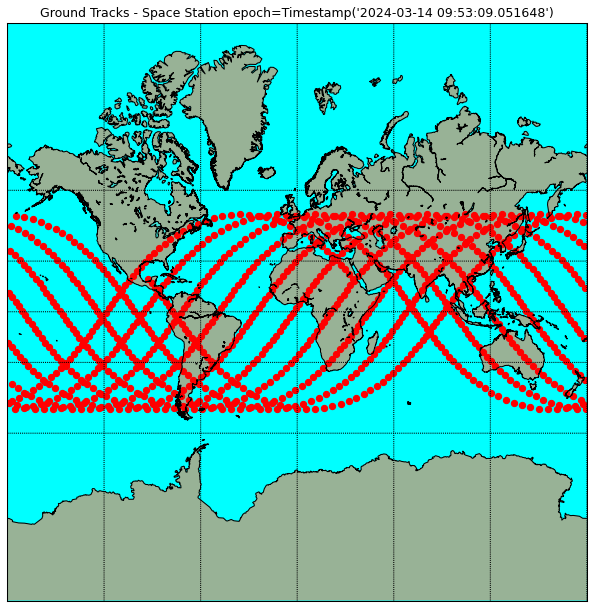

In [97]:
ground_track([gt], f'Ground Tracks - Space Station {epoch=}')

In [45]:
# See Algorithms for Global Positioning, Kai Borre and Gilbert Strang, Wellesley-Cambridge Press, 2012.

def ecef2enu(x_vec, lon_obs, lat_obs):
    clon = np.cos(lon_obs)
    clat = np.cos(lat_obs)
    slon = np.sin(lon_obs)
    slat = np.sin(lat_obs)
    F = np.matrix([[ -slon, -slat*clon, clat*clon],
                   [  clon, -slat*slon, clat*slon],
                   [     0,       clat,      slat]])
    return F.transpose @ x_vec

def azi_ele(enu_vec):
    E = enu_vec.x
    N = enu_vec.y
    U = enu_vec.z
    azi = convert_angle_to_0_2pi_interval(np.arctan2(E,N))
    ele = np.arctan2(U,np.sqrt(N**2 + E**2))
    return azi,ele

def cart2geo(lat, lon, h):
    a = 6378137. # meters
    f = 0.003_352_810_681_183_637_418 # non-dimensional
    N = a/np.sqrt(1.0-f*(2-f)*np.sin(lat)**2)
    X = (N+h)*np.cos(lat)*np.cos(lon)
    Y = (N+h)*np.cos(lat)*np.sin(lon)
    Z = (((1-f)**2)*N + h)*np.sin(lat)
    return X, Y, Z

# test
cart2geo( 57.02929569, 9.950248114, 56.950)

(-4896075.528078086, -2838980.2935610227, 2931226.2884184243)

In [ ]:
# calculate vector from observer to satellite, then determine azimuth and elevation of satelite
def satellite_azi_ele(

In [43]:
f = 0.003_352_810_681_183_637_418

0.0033528106811836376